In [1]:
from keras.applications import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Concatenate, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.layers import Input
import seaborn as sns
import numpy as np
from PIL import Image,ImageOps
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Set the data paths
isolated_train_path = r"D:\Thesis_Final\BanglalekhaIsolet\DATASET\Train"
isolated_test_path = r"D:\Thesis_Final\BanglalekhaIsolet\DATASET\Validation"

In [3]:
img_rows, img_cols = 128 , 128

In [4]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [5]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [6]:
# # Set the image parameters
input_shape = (img_rows, img_cols, 3)
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 20
num_classes = 24

In [7]:
datagen = ImageDataGenerator(rescale=1.0/255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 13258 images belonging to 24 classes.
Found 3316 images belonging to 24 classes.


In [8]:
# Create the individual base models
input_tensor = Input(shape=input_shape)

In [9]:
# Create DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
densenet_output = densenet_model.output
densenet_output = GlobalAveragePooling2D()(densenet_output)

In [10]:
# Create VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg_output = vgg_model.output
vgg_output = GlobalAveragePooling2D()(vgg_output)

In [11]:
# Create InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
inception_output = inception_model.output
inception_output = GlobalAveragePooling2D()(inception_output)

In [12]:
# Create the ensemble model
merged_output = Concatenate()([densenet_output, vgg_output, inception_output])
merged_output = Dense(1024, activation='relu')(merged_output)
merged_output = Dropout(0.5)(merged_output)
predictions = Dense(num_classes, activation='softmax')(merged_output)

ensemble_model = Model(inputs=input_tensor, outputs=predictions)

In [13]:
# Compile the ensemble model
ensemble_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr],
    workers=0  # Set this to 0
)

Epoch 1/50
663/663 [==============================] - 294s 402ms/step - loss: 0.6333 - accuracy: 0.8345 - val_loss: 42.2276 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 2/50
663/663 [==============================] - 197s 297ms/step - loss: 0.2202 - accuracy: 0.9373 - val_loss: 0.3132 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 3/50
663/663 [==============================] - 195s 295ms/step - loss: 0.1799 - accuracy: 0.9491 - val_loss: 12.4892 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 4/50
663/663 [==============================] - 194s 293ms/step - loss: 0.1523 - accuracy: 0.9582 - val_loss: 20.6025 - val_accuracy: 0.6921 - lr: 0.0010
Epoch 5/50
663/663 [==============================] - 195s 295ms/step - loss: 0.1322 - accuracy: 0.9596 - val_loss: 2.0433 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 6/50
663/663 [==============================] - 195s 294ms/step - loss: 0.1352 - accuracy: 0.9635 - val_loss: 3.5138 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 7/50
663/663 [=======================

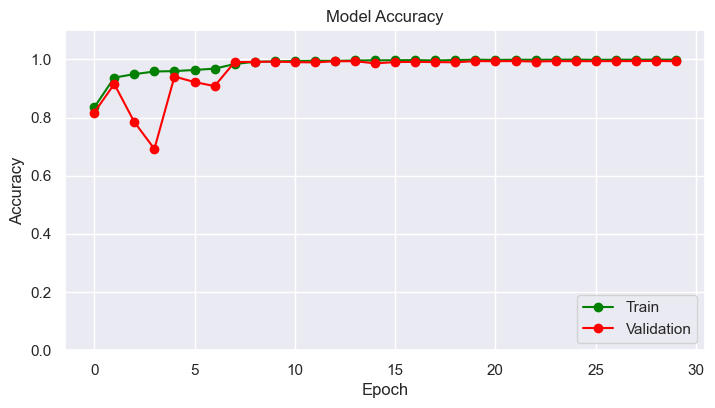

In [17]:
# Plot Accuracy
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.ylim(0, 1.1)
plt.plot(history.history['accuracy'], 'o-', color="Green")
plt.plot(history.history['val_accuracy'], 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.savefig(r'C:\Users\aakav\Downloads\New folder\New folder\Graph\TrainCmater.png')

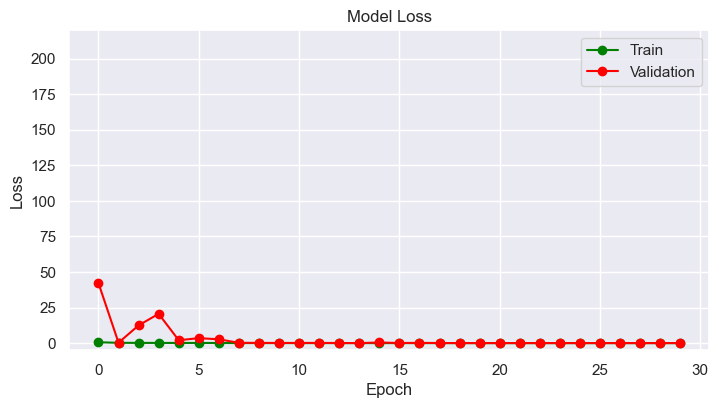

In [18]:
# Plot Loss
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.ylim(-5, 220)
plt.plot(history.history['loss'], 'o-', color="Green")
plt.plot(history.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.savefig(r'C:\Users\aakav\Downloads\New folder\New folder\Graph\TrainCmaterloss.png')

In [19]:
# Evaluate the model on validation data
eval_result = ensemble_model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

# Classification Report
y_true = validation_generator.classes
y_pred_prob = ensemble_model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
class_labels = list(validation_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

166/166 [==============================] - 16s 96ms/step - loss: 0.0449 - accuracy: 0.9934
Validation Loss: 0.044874995946884155, Validation Accuracy: 0.9933655261993408
166/166 [==============================] - 16s 80ms/step
Classification Report:
              precision    recall  f1-score   support

          61       1.00      0.93      0.96       148
          62       1.00      0.99      0.99       150
          63       1.00      1.00      1.00       135
          64       0.99      0.99      0.99       136
          65       0.99      0.99      0.99       129
          66       1.00      1.00      1.00       149
          67       1.00      1.00      1.00       135
          68       1.00      1.00      1.00       149
          69       1.00      1.00      1.00       126
          70       1.00      1.00      1.00       133
          71       0.98      1.00      0.99       133
          72       0.92      1.00      0.96       127
          73       1.00      1.00      1.00    

In [23]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.3f})'.format(i + 61, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


NameError: name 'Y_pred' is not defined

In [29]:
# Confusion Matrix
plt.figure(figsize=(12, 8))
sns.set_theme()
plot_confusion_matrix(ensemble_model, validation_generator, cmap="Blues", display_labels=class_labels)
plt.title("Confusion Matrix")
#plt.savefig(r'C:\Users\aakav\Downloads\New folder\New folder\Graph\ConfusionMatrix.png')
plt.show()

TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

<Figure size 1200x800 with 0 Axes>

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(24, 20))
sns.set_theme()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the matrix using Seaborn heatmap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Customize the plot
heatmap.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=18)
heatmap.set_yticklabels(class_labels, rotation=0, fontsize=18)
plt.xlabel('Predicted Label', fontsize= 20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)

# Save the plot as PNG
confusion_matrix_save_path = r'D:\Thesis_Final\BanglalekhaIsolet\Graph'
plt.tight_layout()  # Adjust layout
plt.savefig(confusion_matrix_save_path, bbox_inches='tight')
plt.show()

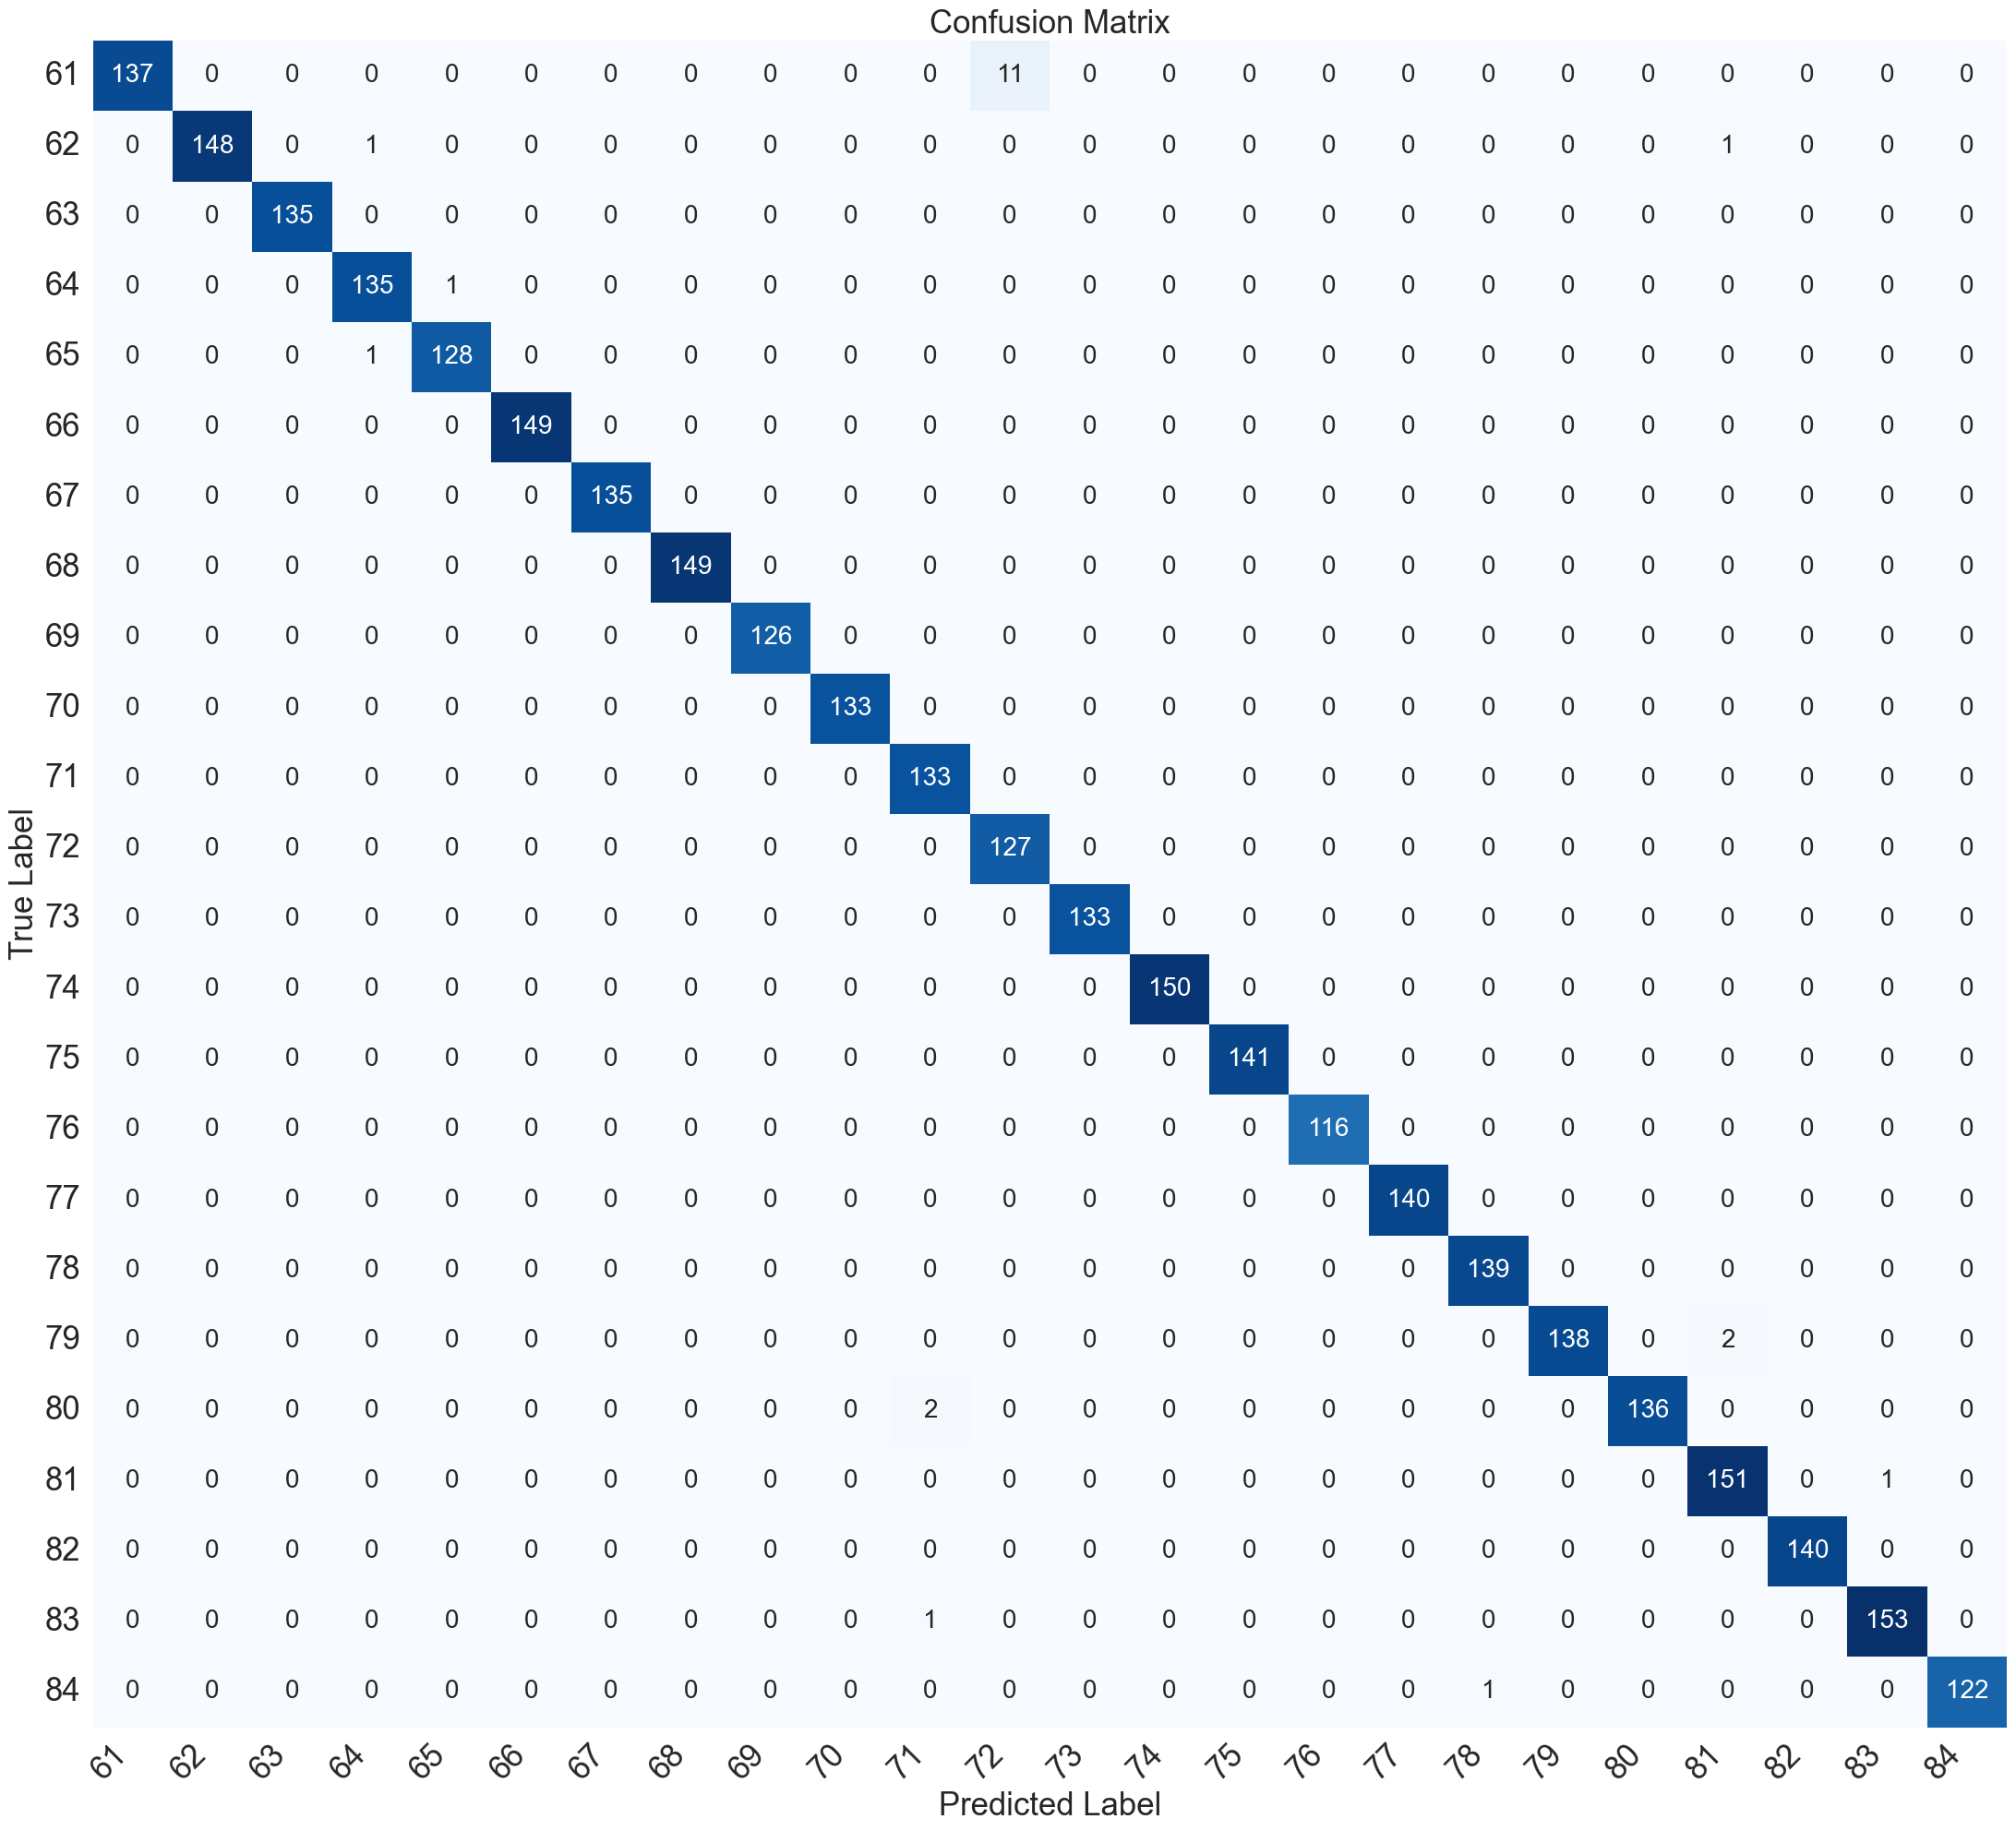

In [41]:
# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(22, 20))
sns.set_theme()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the matrix using Seaborn heatmap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                      annot_kws={"size": 20})  # Adjust the font size inside the heatmap

# Customize the plot
heatmap.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=25)
heatmap.set_yticklabels(class_labels, rotation=0, fontsize=25)
plt.xlabel('Predicted Label', fontsize=25)
plt.ylabel('True Label', fontsize=25)
plt.title('Confusion Matrix', fontsize=25)

# Save the plot as PNG
confusion_matrix_save_path = r'D:\Thesis_Final\BanglalekhaIsolet\ConfusionMatrix.png'
plt.tight_layout()  # Adjust layout
plt.savefig(confusion_matrix_save_path, bbox_inches='tight')
plt.show()


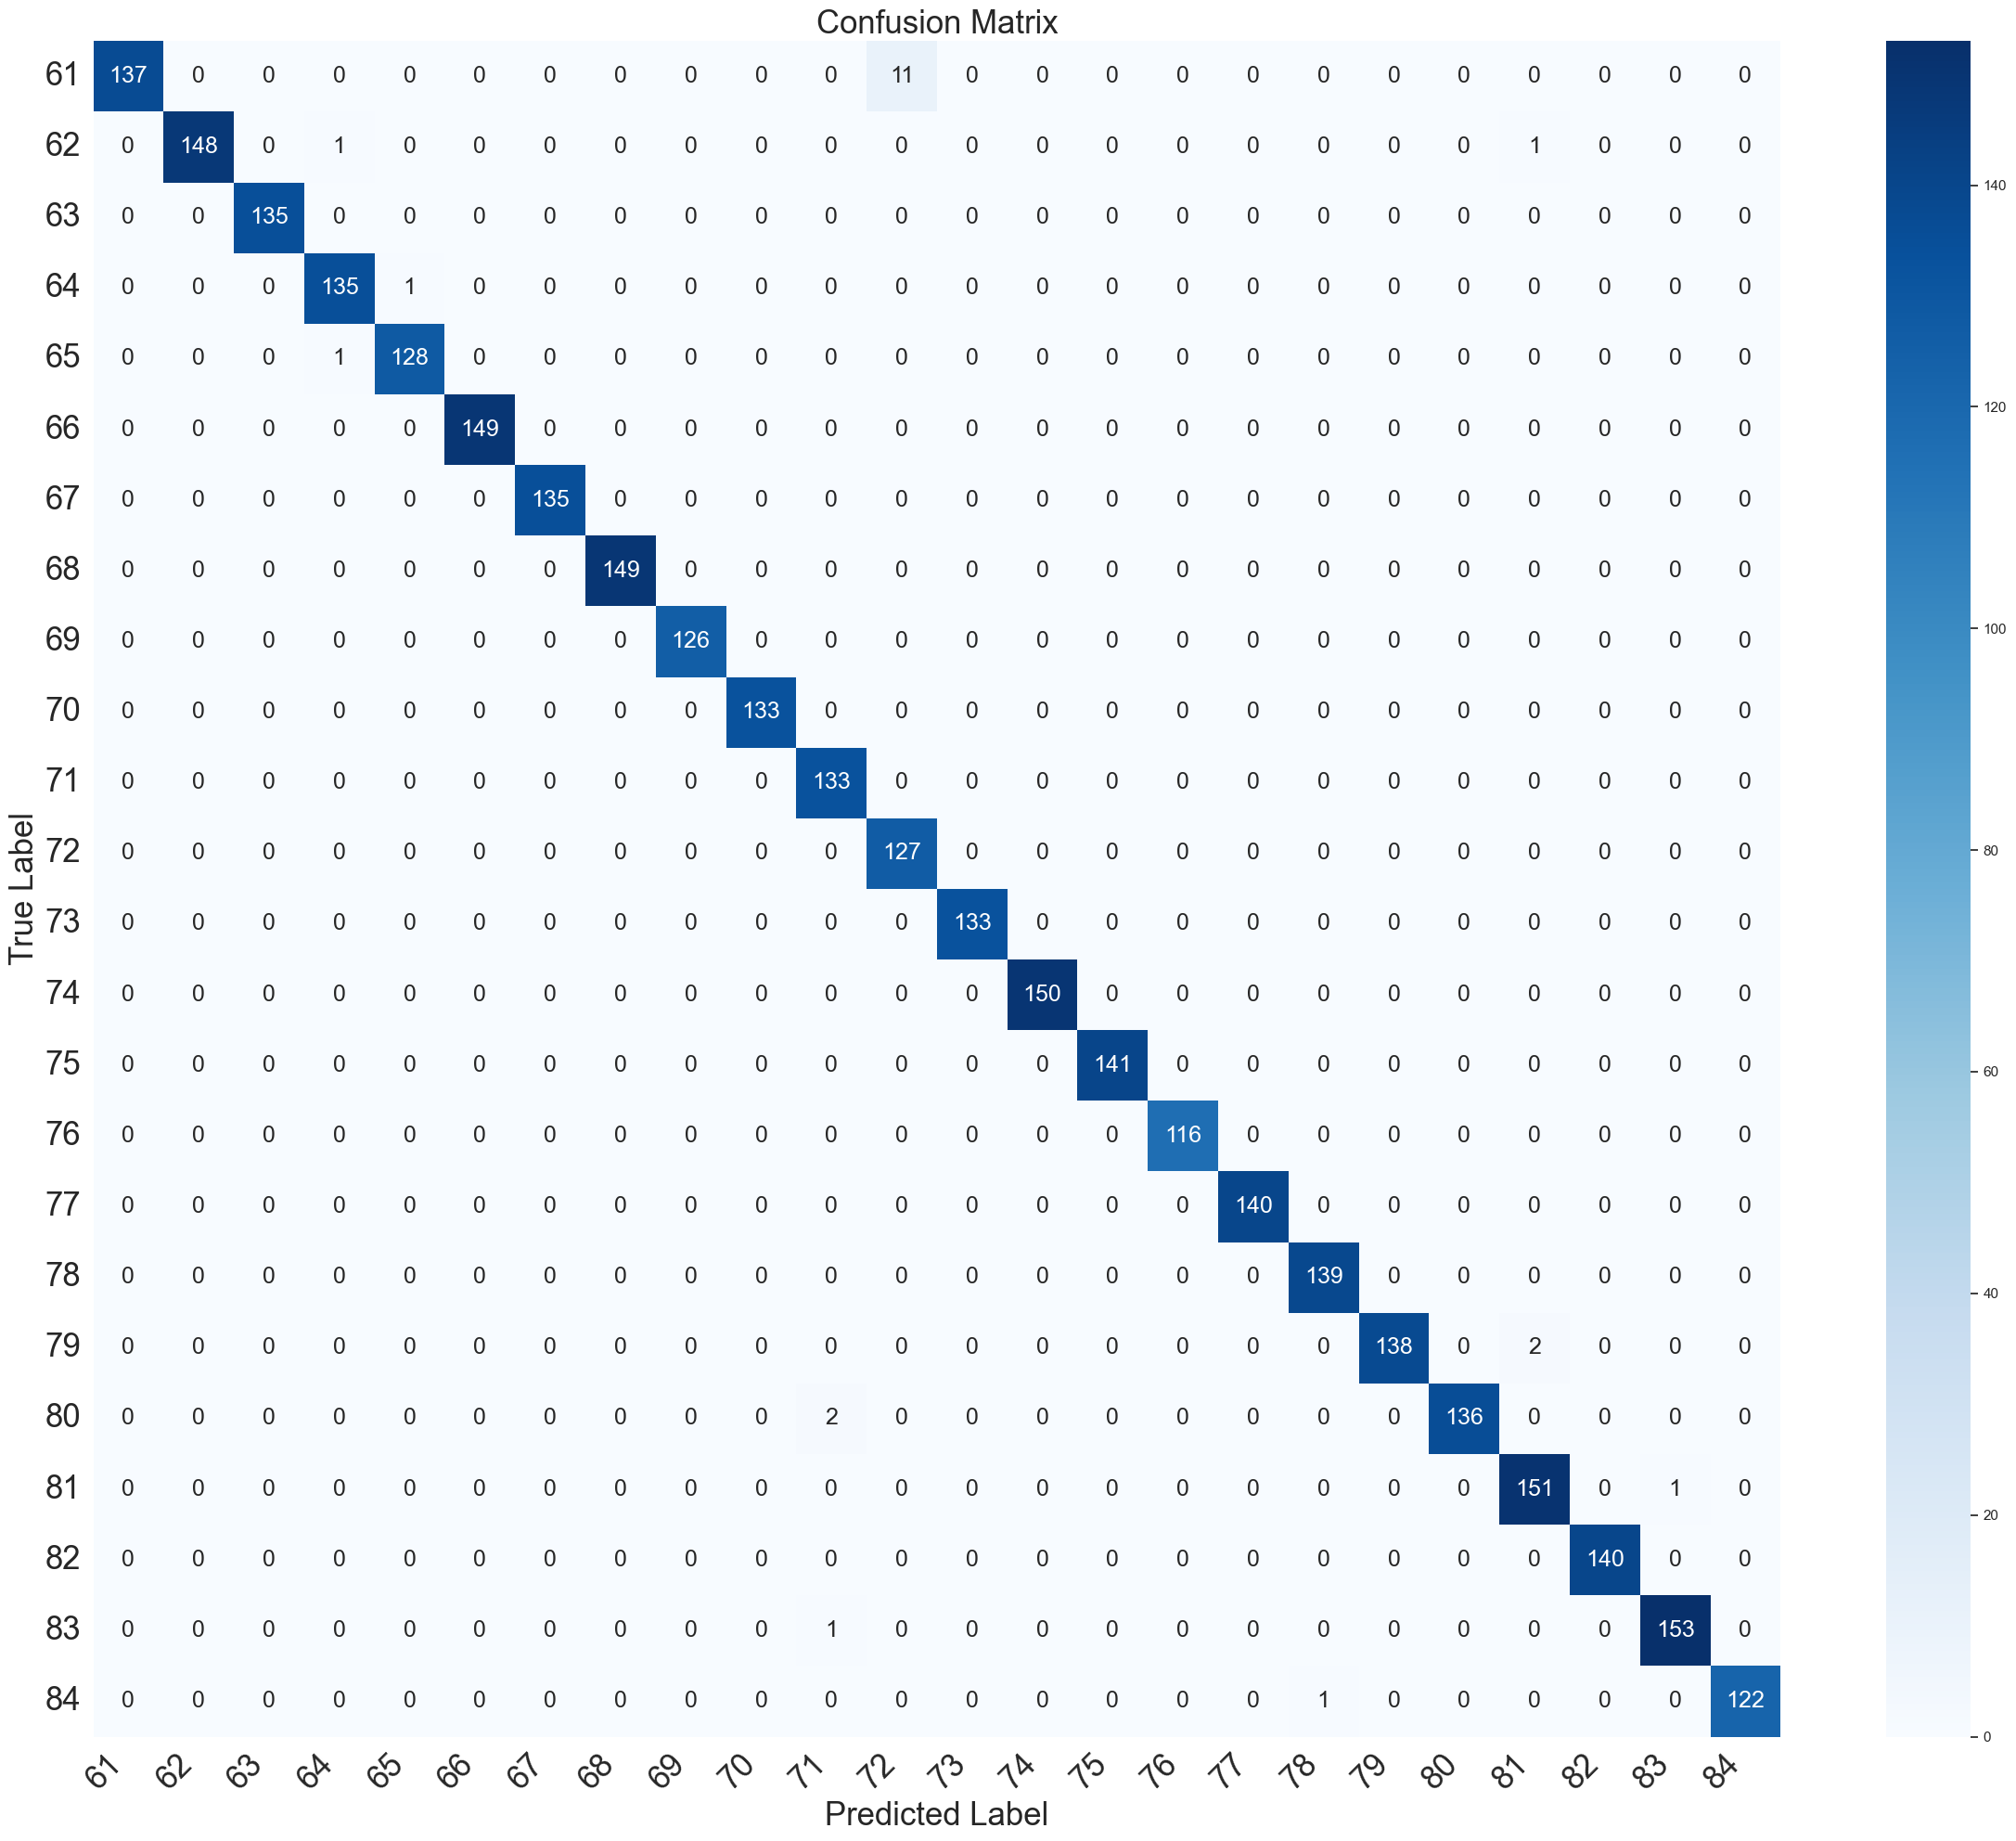

In [49]:
# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(24, 20))
sns.set_theme()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the matrix using Seaborn heatmap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True, cbar_kws={"orientation": "vertical"})

# Customize the plot
heatmap.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=25)
heatmap.set_yticklabels(class_labels, rotation=0, fontsize=25)
plt.xlabel('Predicted Label', fontsize=25)
plt.ylabel('True Label', fontsize=25)
plt.title('Confusion Matrix', fontsize=25)

# Customize font size for diagonal and other text elements
for text in heatmap.texts:
    text.set_size(18)

# Save the plot as PNG
#confusion_matrix_save_path = r'C:\Users\aakav\Downloads\New folder\New folder\Graph\ConfusionMatrix.png'
plt.tight_layout()  # Adjust layout
#plt.savefig(confusion_matrix_save_path, bbox_inches='tight')
plt.show()

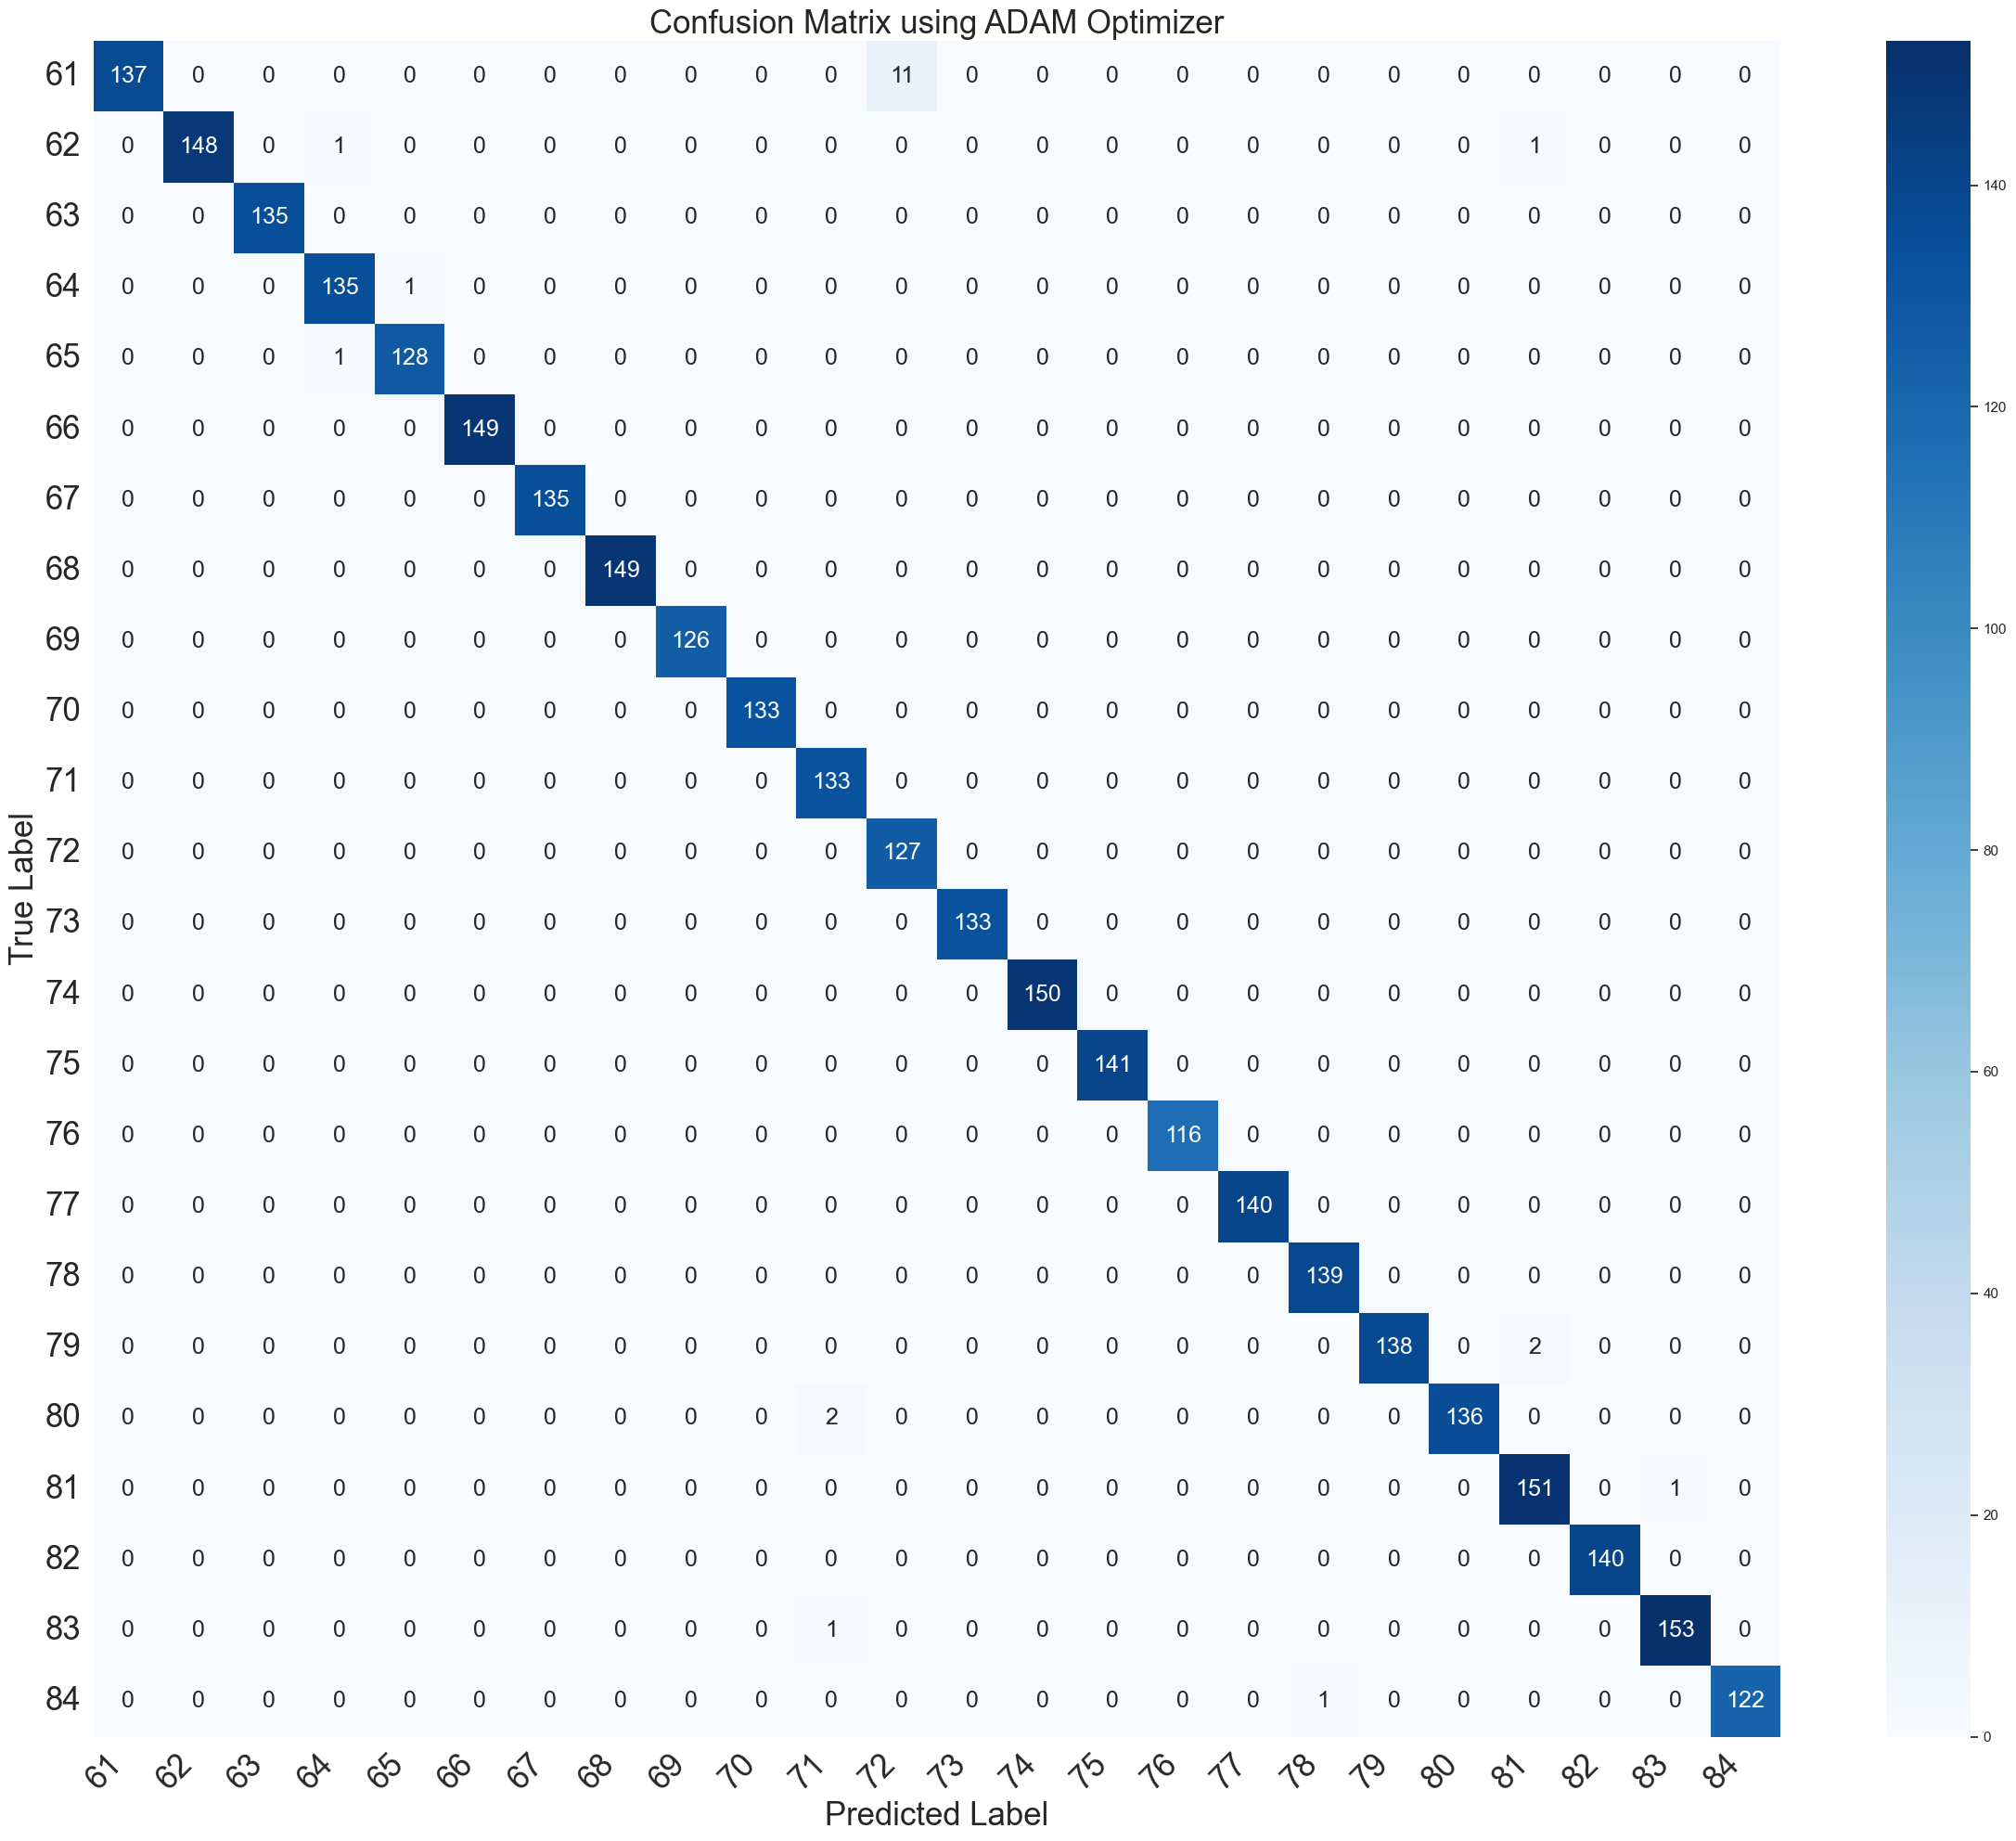

In [52]:
# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(24, 20))
sns.set_theme()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the matrix using Seaborn heatmap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True, cbar_kws={"orientation": "vertical"})

# Customize the plot
heatmap.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=25)
heatmap.set_yticklabels(class_labels, rotation=0, fontsize=25)
plt.xlabel('Predicted Label', fontsize=25)
plt.ylabel('True Label', fontsize=25)
plt.title('Confusion Matrix using ADAM Optimizer', fontsize=25)

# Customize font size for diagonal and other text elements
for text in heatmap.texts:
    text.set_size(18)

# Save the plot as PNG
confusion_matrix_save_path = r'D:\Thesis_Final\BanglalekhaIsolet\ConfusionMatrix_adam.png'
plt.tight_layout()  # Adjust layout
plt.savefig(confusion_matrix_save_path, bbox_inches='tight')
plt.show()
